# Example how to create erzsol input files and run erzsol

In [1]:
# import libraries
import pandas as pd
import numpy as np
import erzsol3Py as erz
import os

## create model

and write to .mod file used by ERZSOL3

Note that ERZSOL3 can either take layer thicknesses as input or the depth of the layers. You need to specify whether depth or layer thickness is given by specifying the layer_mode parameter.

In [2]:
# velocites in km/s, density in kg/m3, depth in km
vp = [2.7, 3.3, 3.8] # P-velocity km/s
vs = [1.8, 2.1, 2.5] # S-velocity in km/s
rho = [2.7, 3.1, 3.2] # denisty in kg/m3
dz = [1.0, 2.0, 5.0] # thickness of each layer in km -> set layer_mode=0 in writeModFile

# depth of layers
# depth = [0.0, 1.0, 3.0] # depth in km -> set layer_mode=1 in writeModFile function
mod_fn = 'example.mod'

In [3]:
erz.writeModFile(vp, vs, rho, layers=dz, layer_mode=0, model_name='myModel', erzsol3_mod_file=mod_fn, nr=1)

In [4]:
# View created mod file
! cat example.mod

myModel
    3        0
1   2.700    1.800     2.70     1.000    0.000     0.000
1   3.300    2.100     3.10     2.000    0.000     0.000
1   3.800    2.500     3.20     5.000    0.000     0.000


## Define receiver and source locations

- shape of receiver locations should be (3, number_of_receivers)
- shape of source location is (1, 3)

In [5]:
receivers = np.array([[0,0,0],[1,1,0],[2,2,0],[3,3,0],[4,4,0]]) # km (cartesian coordinate system)
#print(receivers)
receivers = receivers.T # transpose to shape (3, n_receivers)
print(receivers.shape)
source_coord = np.array([2, 2, 3.5])

dst_fn = 'example.dst'
erz.writeDstFile(receivers, source_coord, dst_fn)

(3, 5)


In [6]:
# view created dst file
! cat example.dst

   5                               # of distances /distances
  4.50      -135.00
  3.77      -135.00
  3.50      0.00
  3.77      45.00
  4.50      45.00


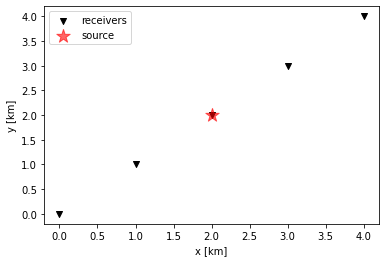

In [7]:
# Plot source and receiver locatios
import matplotlib.pyplot as plt
plt.scatter(receivers[0,:], receivers[1,:], marker='v', color='k')
plt.scatter(source_coord[0], source_coord[1], marker='*', color='r', s=200, alpha=0.6)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.legend(['receivers', 'source'])

## Write the cmd file

The function requires many inputs

In [8]:
cmd_fn = 'example.cmd' # name of cmd file to create

out_fn = 'example.tx.z'# name of output seismogram file that will be created by ERZSOL3

srf_cond = "HS" # surface condition

ntpts = 2048 # Number of time-samples in output seismograms
dt = 0.002 # time step in s

MT = np.array([[0,10,10],[10,10,0],[10,0,10]]) # moment tensor (isotropic source defined here)
sz = source_coord[2] # depth of the source, best to get it from source_coord used to create dst file to avoid modelling errors

dom_freq = 10.0 # center frequency of the source
low_f_taper = (0.125, 0.25) # low frequency taper
high_f_taper = (60.0, 75.0) # high frequency taper
 
min_slow = 0.0001 # minumum slowness s/km
max_slow = 0.7 # maximum slowness s/km

In [9]:
erz.writeCmdFile(cmd_fn, out_fn, mod_fn, dst_fn, 
                 srf_cond, ntpts, dt, MT, sz, dom_freq,
                 low_f_taper, high_f_taper, min_slow, max_slow)

Now that all necessary input files are defined, ERZSOL3 can be run

In [10]:
# Run erzsol3
erzBin = '/Users/nvinard/ErzsolOriginal/bin/erzsol3' # path to erzsol3
cmd = erzBin + ' < example.cmd'
os.system(cmd)

0

In [11]:
! cat example.cmd

"ERZSOL3-ew1  "              Title
"example.tx.z"               File for T-X seismogram output
"example.mod"                              Velocity model file
"HS"                                    Surface Condition (HS,H1,WF,WS)
 10000                                  Number of slownesses (<2500)
 0.0001                                Minimum slowness
 0.7000                                Maximum slowness
10                                      Slowness taper plo (n samples)
10                                      Slowness taper phi (n samples)
"RI"                                    Wavelet input or Ricker (WA/RI)
"ew.wav"                                Wavelet file
"YES"                                    Exponential damping? (YE/NO)
2048                                  Number of time points
  0.002                                   Time step
   0.125  0.250                            Frequency taper (low)
   60.000  75.000                            Frequency taper (high)
   10.0

In [12]:
f_cmd = open('example.cmd', 'r')
lines = f_cmd.read().splitlines()
f_cmd.close()
int(lines[12].split(' ')[0])

2048

Read erzsol output and plot result

In [13]:
data = erz.readErzsol3('example.tx.z', 'example.cmd')
data.shape
#erz.wiggle(data)

(3, 5, 2048)

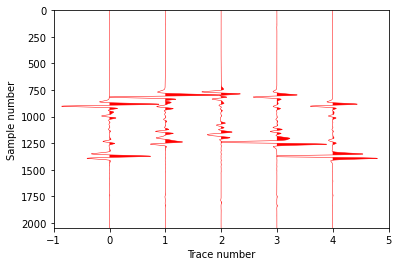

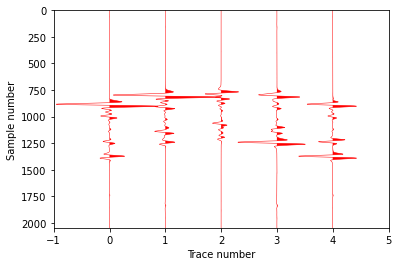

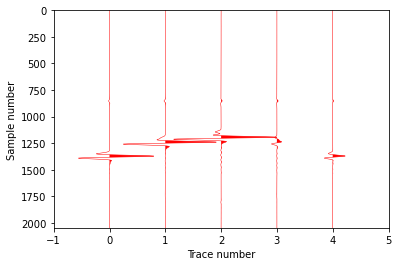

In [14]:
plt.figure(1)
erz.wiggle(data[0,:,:].T)
plt.figure(2)
erz.wiggle(data[1,:,:].T)
plt.figure(3)
erz.wiggle(data[2,:,:].T)